In [11]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [12]:
# Open dataset and normalize data
df = pd.read_csv('joesley_day.csv', index_col=['Date'])
df = df.loc['2017-01-16':, :]
df_norm = np.log(df / df.shift(1)).dropna()
#df_norm = df.pct_change().dropna()

df_norm.head()
print(df_norm.shape)

(85, 44)


In [13]:
# Definir a data da notícia (tratamento)
treatment_date = "2017-05-17"
t0 = df_norm.index.get_loc(treatment_date)

In [14]:
# Série tratada
Y1 = df_norm["EWZ"].values

In [15]:
# Controles
donors = df_norm.drop(columns=["EWZ"])
Y0 = donors.values.T  # (unidades x tempo)

In [16]:
T0 = t0  # número de períodos pré-tratamento
Y1_pre = Y1[:T0]
Y0_pre = Y0[:, :T0]  # shape

k = Y0_pre.shape[0]  # número de controles

# Função objetivo: minimizar o erro quadrático
def objective(w):
    Y_synth = w @ Y0_pre
    return np.sum((Y1_pre - Y_synth) ** 2)

# Restrições:
# 1) soma dos pesos = 1
cons = ({
    "type": "eq",
    "fun": lambda w: np.sum(w) - 1
})

# 2) pesos >= 0
bounds = [(0, 1) for _ in range(k)]

# chute inicial (uniforme)
w0 = np.ones(k) / k

res = minimize(
    objective,
    w0,
    method="SLSQP",
    bounds=bounds,
    constraints=cons
)

weights = res.x


In [39]:
weights.round(4)

array([0.2162, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.1029, 0.024 , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.3107, 0.    , 0.3378,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.0085, 0.    , 0.    ])

In [40]:
selected = {
    etf: w for etf, w in zip(donors.columns, weights.round(4)) if w > 0
}
selected


{'ARGT': np.float64(0.2162),
 'EPU': np.float64(0.1029),
 'EWA': np.float64(0.024),
 'EWW': np.float64(0.3107),
 'EZA': np.float64(0.3378),
 'TUR': np.float64(0.0085)}

In [41]:
EWZ_synth = weights @ Y0
impact = Y1[-1] - EWZ_synth[-1]
impact

np.float64(-0.16044356870594118)

In [42]:
mse = mean_squared_error(Y1[:T0], EWZ_synth[:T0])
rmse = np.sqrt(mse)

print(mse, rmse) #0.011370461757934283

0.00012943697788572926 0.011377037307037772


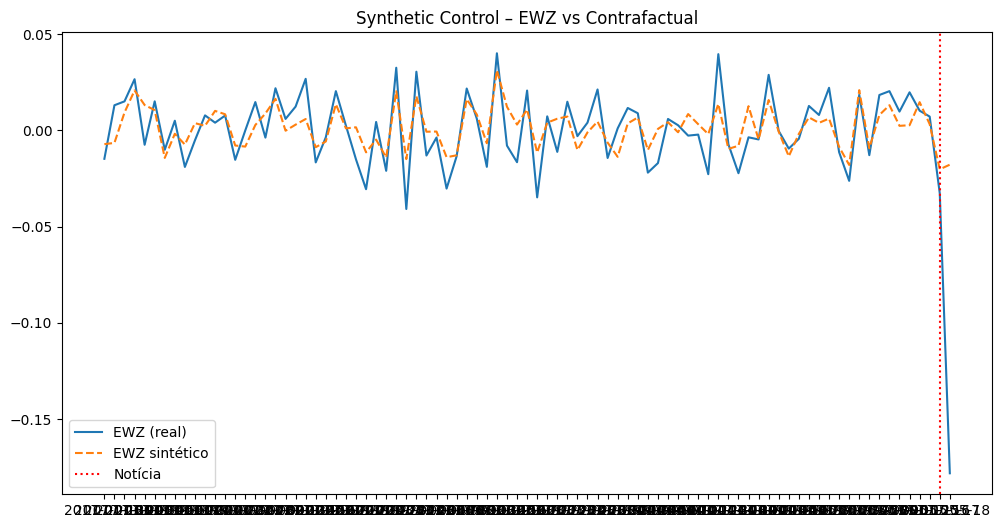

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_norm.index, Y1, label="EWZ (real)")
plt.plot(df_norm.index, EWZ_synth, label="EWZ sintético", linestyle="--")
plt.axvline(df_norm.index[t0], color="red", linestyle=":", label="Notícia")
plt.legend()
plt.title("Synthetic Control – EWZ vs Contrafactual")
plt.show()


---

https://doi.org/10.1080/13504851.2022.2140750